# ProstateX Levelset lesion segmentation


## Import packages

In [24]:
%load_ext autoreload
%matplotlib inline  
import sys
import matplotlib
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Import local packages

In [25]:
rel = "../"
sys.path.append(rel+'src')
sys.path.append(rel+'lib')
import prostatex.dataset
import prostatex.model
from prostatex.preprocessing import get_roi_in_mm, pad_zero
from prostatex.classification import train_test_split
print ("PACKAGES LOADED")

PACKAGES LOADED


## Specify parameters

Following is using trail dataset (only ten ProstateX) patients. To download rest of the cases check the challenge's website (http://spiechallenges.cloudapp.net/competitions/6).

To prepare the train/test dataset follow the file / directory naming convention. 

File:
 - lesion-information/ProstateX.csv

is automatically generated 

In [26]:
# Dataset directory (trail)
dataset_dir = rel+"data/ProstateX/train"

# ROI (region of interest) width and depth in mm
roi_width_mm=30
roi_depth_mm=0

### Show available tensorflow devices

## Create dataset for data manipulation

In [27]:
dataset = prostatex.dataset.DataSet(dataset_dir)
data = dataset.data_aslist()

## Define some helper functions for data batch generation 

In [28]:
from numpy import reshape
from numpy import take
from functools import reduce

'''
Return biggest shape from supplied by volume
'''
def get_biggest_shape(shapes):
    # print('get_biggest_shape',shapes)
    biggest_shape = None
    biggest_shape_volume = None
    for shape in shapes:
        shape_volume = int(reduce(lambda x, y: x*y,shape)) 
        if biggest_shape is None or biggest_shape_volume < shape_volume:
            biggest_shape = shape
            biggest_shape_volume = shape_volume
    # print('get_biggest_shape, out: ',biggest_shape)
    return biggest_shape

'''
Get data (features/image) for model
Given that current method uses 3 modalities, output will be 4 dimentional [x,y,z,m] - where:
- x,y are widht/height corresponding to i and j 
- z is depth corresponding to k
- m is index of modality

To match the dimensions between modalities, data is zero-padded to the biggest shape
'''  
def get_model_x(model,roi_width_mm,roi_depth_mm):
    #Get region of interest of three modalities
    model_roi_ktrans = get_roi_in_mm(model,'ktrans',roi_width_mm,roi_depth_mm)
    model_roi_dwiadc = get_roi_in_mm(model,'dwi-adc',roi_width_mm,roi_depth_mm)
    model_roi_t2tra = get_roi_in_mm(model,'t2-tra',roi_width_mm,roi_depth_mm)
    biggest_shape = get_biggest_shape([model_roi_ktrans.shape,model_roi_dwiadc.shape,model_roi_t2tra.shape])
    target_shape = biggest_shape
    model_roi_ktrans = pad_zero(model_roi_ktrans,target_shape)
    model_roi_dwiadc = pad_zero(model_roi_dwiadc,target_shape)
    model_roi_t2tra = pad_zero(model_roi_t2tra,target_shape)
    model_x = np.zeros([*target_shape,3])
    model_x[:,:,:,0] = model_roi_ktrans
    model_x[:,:,:,1] = model_roi_dwiadc
    model_x[:,:,:,2] = model_roi_t2tra
    return model_x
    
# Return one hot representation given possible_values
def one_hot(value, possible_values):
    return np.eye(len(possible_values))[value]

'''
Get batch from the data
Given that current method uses 3 modalities

X output will be 5 dimentional [i,x,y,z,m] - where:
- x,y are widht/height corresponding to i and j 
- z is the depth corresponding to k
- m is the index of modality
- i is the index of the single model features

Y output (labels) is 2 dimentional because currently network uses one-hot representation for true/false labels (to be corrected)
'''  
def get_batch(data,batch_len,batch_num,roi_width_mm,roi_depth_mm):
    batch_num  = int(batch_num % (len(data)/batch_len))
    start = max(0,batch_len*batch_num)
    end = min(len(data),start+batch_len)
    batch = data[start:end]
    significance_values = [True,False]
    n_values = len(significance_values)
    x = None 
    y = np.zeros([len(batch),len(significance_values)])
    for i in range(len(batch)):
        model =batch[i]
        try:
            model_x = get_model_x(model,roi_width_mm,roi_depth_mm)
            if x is None:
                x = np.zeros([len(batch),*model_x.shape])
            else:
                model_x = pad_zero(model_x,[*x.shape[1:]])
            x[i,:,:,:,:] = model_x
            y[i,:] = one_hot(int(model.clinical_features().significance()),significance_values)
        except ValueError as e:
            print('Could not assign value',e, model)
        except KeyError as e:
            print('Could not find modality',e, model)
    return x, y

'''
Return batch data and labels from data 
'''
def get_batch_xy(data_x,data_y,batch_len,batch_num):
    data_len = len(data_x)
    indexes = range(data_len)
    batch_num  = int(batch_num % (len(data)/batch_len))
    start = max(0,batch_len*batch_num)
    end = min(len(data),start+batch_len)
    indexes = indexes[start:end]
    x = take(data_x,indexes,0)
    y = take(data_y,indexes,0)
    return x,y
    
'''
Get data and labels for all entries in data
'''
def get_xy(data,roi_width_mm,roi_depth_mm):
    return get_batch(data,len(data),0,roi_width_mm,roi_depth_mm)

In [29]:
import numpy as np
import matplotlib.pyplot as plt
import math


def plot_all(imgdata, dims=None, vmin=None, vmax=None,):
    my_dpi = 96
    w, h, d =imgdata[0].shape
    
    ms = math.floor(d/2)
    columns = rows = math.ceil(math.sqrt(len(imgdata)))
    if dims is not None:
        columns,rows = dims
    fig=plt.figure(figsize=(800/my_dpi, 800/my_dpi), dpi=my_dpi)
    for i in range(len(imgdata)):
        fig.add_subplot(rows, columns, i+1)
        try:
            plt.imshow(imgdata[i][:,:,ms], vmin=vmin, vmax=vmax)
        except:
            pass
    plt.show()
    
    
def get_roi_data(data, modality):
    return [get_roi_in_mm(data,modality,roi_width_mm,0) for data in data if modality in data.images]

def plot_all_transform(data,modality,transformation):
    return plot_all([transformation(roi) for roi in get_roi_data(data,modality)])
    

In [30]:
def norm(data):
    return data/data.max()

def norm_sd(data):
    return ( data - np.mean(data) )/ np.std(data)

## Display ROIs for one case 

In [31]:
clinsig_data = [x for x in data if x.clinical_features().significance()] 
not_clinsig_data = [x for x in data if not x.clinical_features().significance()] 

print('Len clinsig:',len(clinsig_data))
print('Len not clinsig:',len(not_clinsig_data))
display_test_model = clinsig_data[0]

print('Id:',display_test_model.id())
print('Clinical significance:',display_test_model.clinical_features().significance())

Len clinsig: 78
Len not clinsig: 249
Id: ProstateX-0000
Clinical significance: True


### Ktrans CLINSIG

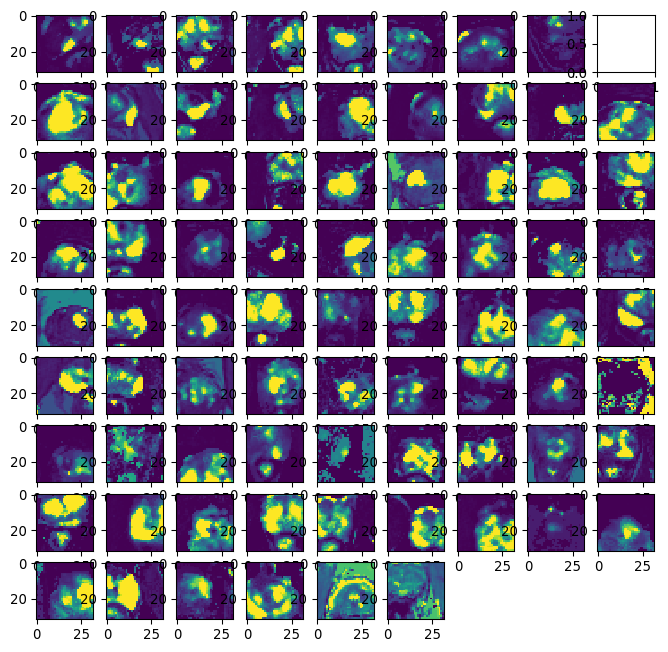

In [32]:
plot_all(get_roi_data(clinsig_data,'ktrans'))

### Ktrans NOTCLINSIG

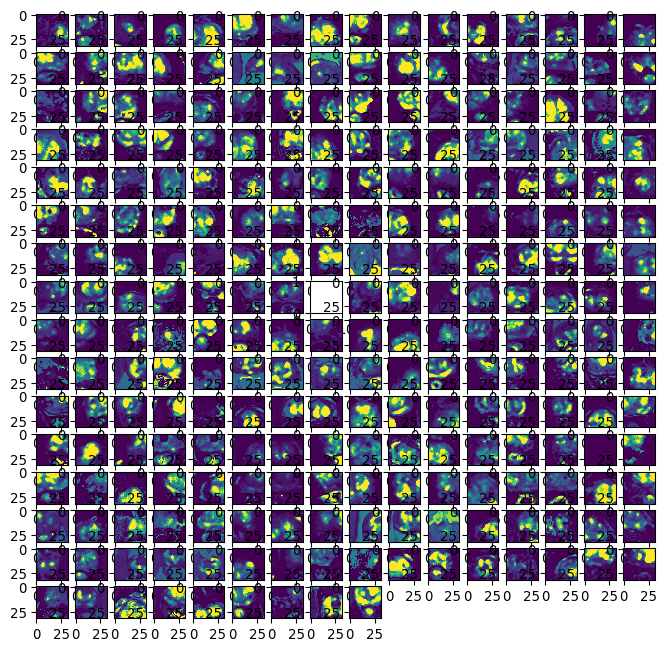

In [33]:
plot_all(get_roi_data(not_clinsig_data,'ktrans'))

### DWI-ADC CLINSIG

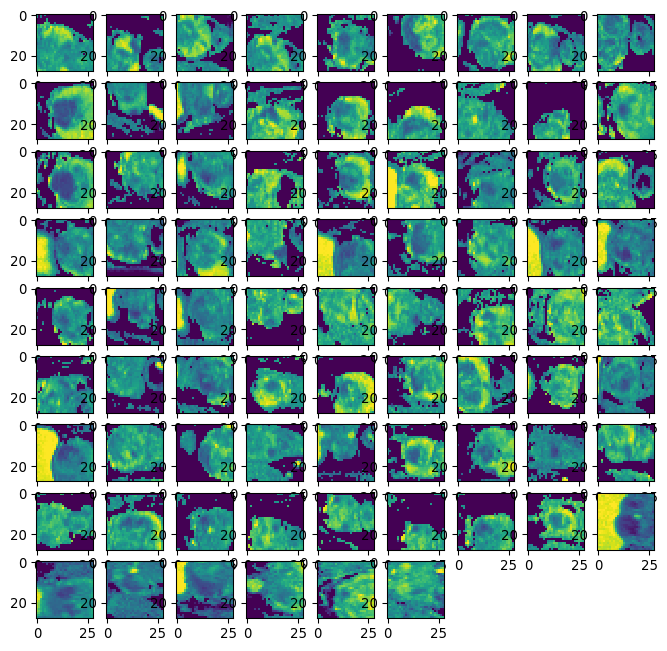

In [34]:
plot_all(get_roi_data(clinsig_data,'dwi-adc'))

### DWI-ADC NOT CLINSIG

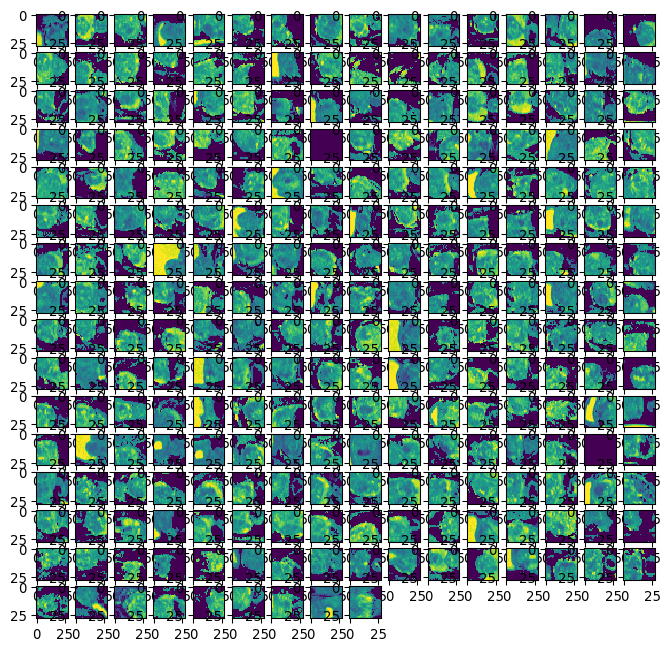

In [35]:
plot_all(get_roi_data(not_clinsig_data,'dwi-adc'))

### T2-TRA CLINSIG

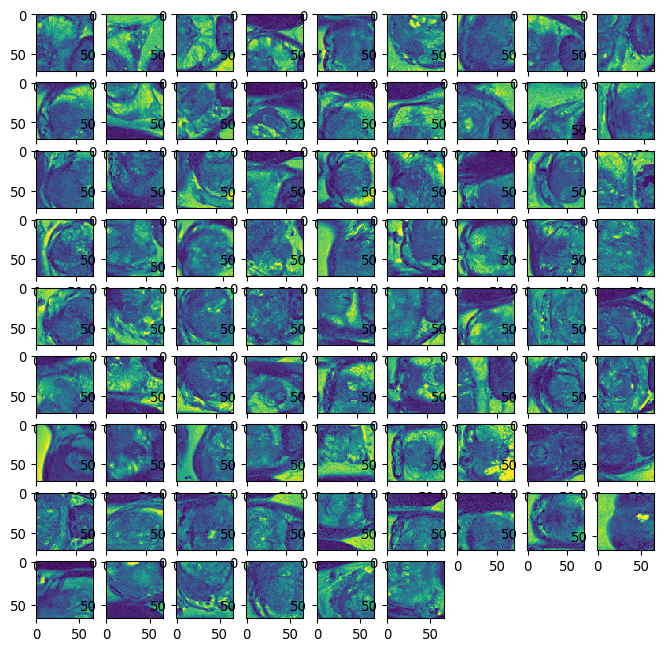

In [36]:
plot_all(get_roi_data(clinsig_data,'t2-tra'))

### T2-TRA NOT CLINSIG

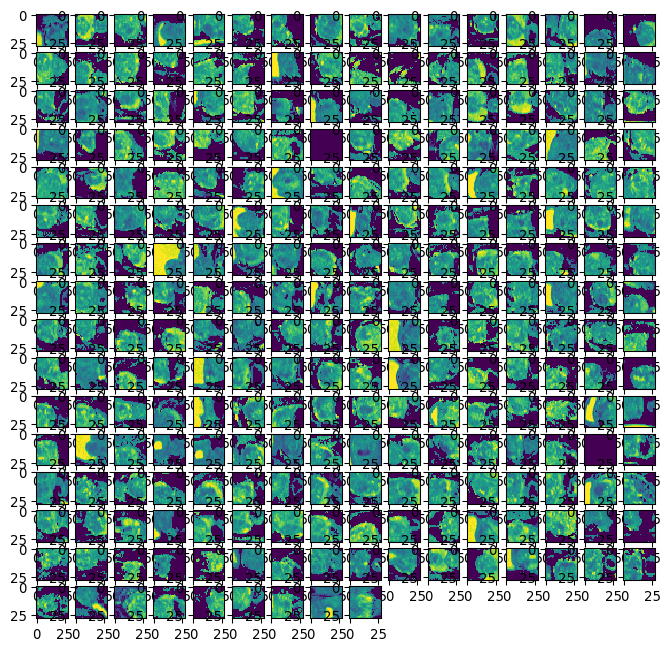

In [37]:
plot_all(get_roi_data(not_clinsig_data,'dwi-adc'))

In [38]:
import morphsnakes.morphsnakes as morphsnakes

In [39]:
def plot3d(data):
    plot_all([data[:,:,i] for i in range(data.shape[2])])

In [40]:
def apply_mask(inimg,mask):
    img = np.copy(inimg)
    img[mask==0] = 0
    return img

def correct_mask(inimg, mask, desc_func=np.median, prefer_hyperintensity = True):
    img = apply_mask(inimg,mask)
    img_inv = apply_mask(inimg,mask==0)
    
    desc_img = desc_func(img[img>0])
    desc_img_inv = desc_func(img_inv[img_inv>0])
    
    
    if prefer_hyperintensity and desc_img < desc_img_inv:
        return np.zeros(img.shape), np.zeros(img.shape)
    elif not prefer_hyperintensity and desc_img > desc_img_inv:
        return np.zeros(img.shape), np.zeros(img.shape)
    else:
        return img, mask

In [41]:
import scipy
from scipy import ndimage
import matplotlib.pyplot as plt

def sharpen(img, alpha = 30):
    blurred_f = ndimage.gaussian_filter(img, 3)
    filter_blurred_f = ndimage.gaussian_filter(blurred_f, 1)
    sharpened = blurred_f + alpha * (blurred_f - filter_blurred_f)
    return sharpened
    

In [42]:
import math 
import morphsnakes.morphsnakes as morphsnakes
import scipy.ndimage
import skimage.filters.rank as rnk
#http://scikit-image.org/docs/dev/api/skimage.filters.rank.html
from skimage.morphology import disk


zoom_t2 = 1 * 2
zoom_dwi = 3.75 * 2
zoom_ktrans = 3 * 2

def find_closest_shape(img,point):
    from scipy.ndimage.measurements import label
    from matplotlib import pyplot as ppl
    from math import hypot

    
    labelled, num_features = label(img)
    dists = []
    for feat in range(1, num_features+1):
        size = len(labelled[labelled == feat])
        indxs = np.where(labelled[:,:] == feat)
        x_mean = np.mean(indxs[0])
        y_mean = np.mean(indxs[1])
        dist = hypot(x_mean-point[0],y_mean-point[1])
        dists.append(dist)
    if len(dists) ==0:
        return img
    out =  np.array((labelled == np.argmin(dists)+1)[:,:],dtype=np.float)
    return out

def and_not_none(data):
    sum_all = None
    for elem in data:
        if elem is not None:
            if sum_all is None:
                sum_all = np.copy(elem>0)
            else:
                sum_all = np.logical_and(elem>0,sum_all)
    return sum_all

In [43]:
def show_img(image,vmin=None,vmax=None):
    plt.figure()
    plt.imshow(image,vmin=vmin,vmax=vmax)
    plt.show()

def show_img_mask(model, whole, image, results, segment, mask, vmin=None,vmax=None):
    from matplotlib import pyplot as ppl
    # Prepare the visual environment.
    fig = ppl.gcf()
    fig.clf()
    fig.set_dpi(300)
    
    ax0 = fig.add_subplot(1, 3, 1)
    ax0.imshow(whole, cmap=ppl.cm.gray)
    
    ax1 = fig.add_subplot(1, 3, 2)
    ax1.imshow(image, cmap=ppl.cm.gray,vmin=vmin,vmax=vmax)
    
    
    colors = {
        't2-tra': 'b',
        't2-g': 'cyan',
        't2-g-3': 'cyan',
        't2-g-6': 'cyan',
        't2-g-9': 'cyan',
        'dwi-adc': 'y',
        'ktrans': 'g',
        'mask': 'r'
    }
    
    contours = {}
    for name, config in results.items():
        if config is not None and 'mask' in config and config['mask'] is not None:
            contours[name] = ax1.contour(config['mask']>0, [0.25], colors=colors[name])
    ax1.contour(results['mask']['mask']>0, [0.5], colors='r')
    
    
    print(colors)

    ax1 = fig.add_subplot(1, 3, 3)
    ax1.imshow(segment, cmap=ppl.cm.gray,vmin=vmin,vmax=vmax)
    
    ppl.show()
    
def sum_not_none(data):
    sum_all = None
    for elem in data:
        if elem is not None:
            if sum_all is None:
                sum_all = np.copy(elem)
            else:
                sum_all += elem
    return sum_all
    

def and_not_none(data):
    sum_all = None
    for elem in data:
        if elem is not None:
            if sum_all is None:
                sum_all = np.copy(elem>0)
            else:
                sum_all = np.logical_and(elem>0,sum_all)
    return sum_all

def as_int(mat):
    return np.array(mat,dtype=np.float)
    
def cutoff(mask, prob):
    if mask is None:
        return None
    return as_int(mask>=prob)
    

def img_modality_2d(model,modality):
    return model.images[modality].imgdata()[:,:,model.images[modality].ijk()[2]]
    
def get_method_config(extraction_config, name):
    for config in extraction_config['methods']:
        if config['name'] is name:
            return config
    return None

def mask_weighted(config, results):
    weight_cumulated = 0
    mask_weighted = None
    for res in results:
        if res is not None and 'name' in res:
            if res['mask'] is not None and  res['mask'].max() == 1:
                weight = get_method_config(config, res['name'])['weight']
                weight_cumulated += weight
                if mask_weighted is None:
                    mask_weighted = weight * res['mask']
                else:
                    mask_weighted += weight * res['mask']
    if mask_weighted is None:
        return None
    return mask_weighted / weight_cumulated
    
def do_extract(extraction_config, context, method_name, model):
    method_config = get_method_config(extraction_config, method_name)
    roi, mask, segment = method_config['func'](extraction_config, context, model)
    return {
        method_name:{
            'name': method_name,
            'modality':method_config['modality'],
            'roi': roi,
            'mask': mask,
            'segment':segment
        }
    }
    
def do_segment(extraction_config, model, mask=None, smoothing=1, prob = 0.5):
    context = {
        'mask':{
            'name':'mask',
            'roi':None,
            'mask':mask,
            'segment':mask
        },
        'masks':[]
    }
    for config in extraction_config['methods']:
        context[config['name']] = {
            'name': config['name'],
            'roi': None,
            'segment': None,
            'mask': None
        }
    
    for config in extraction_config['methods']:
        if 'modality' in config and config['modality'] in model.images:
            print('Processing: ',config['name'])
            res = do_extract(extraction_config, context, config['name'], model)
            context.update(res)
            context['masks'].append(res[config['name']]['segment'])
    
    mask_w = mask_weighted(extraction_config, context.values())
    mask = cutoff(mask_w, prob=prob)
    mask = find_closest_shape(mask, [dim/2 for dim in mask.shape])
    for i in range(smoothing):
        mask = morphsnakes.curvop(mask)
    context['mask']['mask'] = mask
    context['mask']['segment'] = mask_w
    return context

def segment(data, extraction_config, iters=1, smoothing=3, prob = 0.5):
    segments = []
    for model in data:
        print(model.id())
        results = {
            'mask':{
                'segment':None,
                'mask':None
            }
                  
          }
        for i in range(iters):
            results = do_segment(extraction_config, model, results['mask']['mask'], smoothing=smoothing, prob=prob)
        for name, config in results.items():
            if config is not None and 'modality' in config:
                img = img_modality_2d(model, config['modality'])
                print('Plotting results on:',name)
                show_img_mask(model, img, config['roi'], results, segment=config['segment'], mask=config['mask'])
        segments.append(results['mask'])
    return segments
        
    

In [44]:

def circle_levelset(shape, center, sqradius, scalerow=1.0):
    """Build a binary function with a circle as the 0.5-levelset."""
    grid = np.mgrid[list(map(slice, shape))].T - center
    phi = sqradius - np.sqrt(np.sum((grid.T)**2, 0))
    u = np.float_(phi > 0)
    return u

def roi_lesion_location(img):
    return [math.floor(dim/2) for dim in img.shape]

def obtain_roi_to_segment(model, modality, zoom, roi_width_mm=roi_width_mm, roi_depth_mm=0):
    roi_img = get_roi_in_mm(model, modality, roi_width_mm, roi_depth_mm)
    roi_img = roi_img[:,:, math.floor(roi_img.shape[2]/2) ]
    roi_img = norm(roi_img)
    roi_img = scipy.ndimage.zoom(roi_img, zoom, order=3)
    return roi_img

def obtain_roi(model, modality):
    zoom = {
        't2-tra': 1 * 2,
        'dwi-adc': 3.75 * 2,
        'ktrans': 3 * 2
    }[modality]
    return obtain_roi_to_segment(model, modality, zoom, roi_width_mm, 0)
    
def morphACWE(roi, smoothing, num_iters, lambda1, lambda2, initial_levelset=None, prefer_hyperintensity=False):
    from matplotlib import pyplot as ppl
    les_loc = roi_lesion_location(roi)
    msnake = morphsnakes.MorphACWE(roi, smoothing=smoothing, lambda1=lambda1, lambda2=lambda2)
    if initial_levelset is None:
        msnake.levelset = circle_levelset(roi.shape, les_loc, 5)
    else:
        msnake.levelset = initial_levelset + circle_levelset(roi.shape, les_loc, 5)
    msnake.run(num_iters)
    mask = msnake.levelset
    mask = find_closest_shape(mask, les_loc)
    segment, mask = correct_mask(roi, mask, prefer_hyperintensity=prefer_hyperintensity)
    return roi, mask, segment


def morphACWE_ktrans(config, context, model):
    roi = obtain_roi(model,'ktrans')
    roi, mask, segment = morphACWE(roi, num_iters=40, smoothing = 0, lambda1=1, lambda2=1, prefer_hyperintensity=True)
    return roi, mask, segment

    
def morphACWE_dwi_adc(config, context, model):
    roi = obtain_roi(model,'dwi-adc')
    roi = sharpen(roi, alpha=10)
    initial_levelset=cutoff(mask_weighted(config, [context['ktrans'], context['mask']]), prob=0.5)
    roi, mask, segment = morphACWE(roi, num_iters=40, smoothing = 0, lambda1=10, lambda2=3, initial_levelset=initial_levelset, prefer_hyperintensity=False)
    return roi, mask, segment
     
def morphACWE_t2_tra(config, context, model):
    roi = obtain_roi(model,'t2-tra')
    initial_levelset=cutoff(mask_weighted(config, [context['ktrans'], context['dwi-adc'], context['t2-g-3'], context['t2-g-6'], context['t2-g-9'], context['mask']]), prob=0.5)
    roi, mask, segment = morphACWE(roi, num_iters = 40, smoothing = 0, lambda1 = 6, lambda2 = 4, initial_levelset=initial_levelset, prefer_hyperintensity=False)
    return roi, mask, segment

def morphACWE_t2_tra_g(config, context, model, disk_size, p0=0.1, p1=0.5, initial_levelset=None, prefer_hyperintensity=False):
    roi = get_roi(model,'t2-tra',roi_width_mm,0)#roi_depth_mm)
    roi = rnk.gradient_percentile(norm(roi),disk(disk_size), p0=p0, p1=p1)
    roi = norm(roi)
    roi = scipy.ndimage.zoom(roi, zoom_t2, order=3)
    roi, mask, segment = morphACWE(roi, num_iters=40, smoothing = 0, lambda1=1, lambda2=1, initial_levelset=initial_levelset, prefer_hyperintensity=prefer_hyperintensity)
    return roi, mask, segment


def morphACWE_t2_tra_g3(config, context, model):
    initial_levelset=cutoff(mask_weighted(config, [context['ktrans'], context['dwi-adc'], context['mask']]), prob=0.5)
    return morphACWE_t2_tra_g(config, context, model, disk_size = 3, p0 = 0.1, p1= 0.5, initial_levelset=initial_levelset, prefer_hyperintensity=False)


def morphACWE_t2_tra_g6(config, context, model):
    initial_levelset=cutoff(mask_weighted(config, [context['ktrans'], context['dwi-adc'], context['mask']]), prob=0.5)
    return morphACWE_t2_tra_g(config, context, model, disk_size = 6, p0 = 0.1, p1 = 0.5, initial_levelset=initial_levelset, prefer_hyperintensity=False)


def morphACWE_t2_tra_g9(config, context, model):
    initial_levelset=cutoff(mask_weighted(config, [context['ktrans'], context['dwi-adc'], context['mask']]), prob=0.5)
    return morphACWE_t2_tra_g(config, context, model, disk_size = 9, p0 = 0.1, p1 = 0.5, initial_levelset=initial_levelset, prefer_hyperintensity=False)


In [45]:
 extraction_config = {
        'methods':[
            {
                'name': 'ktrans',
                'modality': 'ktrans',
                'weight': 1,
                'func': morphACWE_ktrans
            },
            {
                'name': 'dwi-adc',
                'modality': 'dwi-adc',
                'weight': 1,
                'func': morphACWE_dwi_adc
            },
            {
                'name': 't2-g-3',
                'modality': 't2-tra',
                'weight': 0.40,
                'func': morphACWE_t2_tra_g3
            },
            {
                'name': 't2-g-6',
                'modality': 't2-tra',
                'weight': 0.40,
                'func': morphACWE_t2_tra_g6
            },
            {
                'name': 't2-g-9',
                'modality': 't2-tra',
                'weight': 0.20,
                'func': morphACWE_t2_tra_g9
            },
            {
                'name': 't2-tra',
                'modality': 't2-tra',
                'weight': 0.05,
                'func': morphACWE_t2_tra
            },
            {
                'name':'mask',
                'weight': 1
            },
        ]
    }

In [46]:
segments = segment(clinsig_data, extraction_config, iters=1, smoothing=1, prob=0.25)

ProstateX-0000
Processing:  ktrans


NameError: name 'get_roi' is not defined

In [ ]:
segments = segment(not_clinsig_data, extraction_config, iters=2, smoothing=1, prob=0.33)